<a href="https://colab.research.google.com/github/nyoons/ESAA/blob/main/2022_11_25_%EA%B3%BC%EC%A0%9C_%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>**04. 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측**

다양한 종류의 선형 기반 회귀를 구현해주는 사이킷런의 linear_models 모듈.

**LinearRegression 클래스 - Ordinary Least Squares**

예측값과 실제 값의 RSS를 최소화해 OLS 추정 방식을 구현한 클래스. fit 메서드로 X, y 입력 받으면 회귀계수인 W를 coef_ 속성에 저장.

In [1]:
class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

#fit_intercpet : 디폴트는 True, intercept 값을 계산할지 말지 지정.

SyntaxError: ignored

OLS 기반의 회귀 계수 계산은 입력 피처의 독립성에 많은 영향을 받음. 다중공선성 문제.

**회귀 평가 지표**

실제 값과 회귀 예측값의 차이 값을 기반으로 한 지표가 중심.
* MAE : 차이를 절대값으로 변환해 평균한 것. metrics.mean_absolute_error
* MSE : 차이를 제곱해 평균한 것. metrics.mean_squared_error
* RMSE : 오류의 제곱은 실제 오류 평균보다 크니까 MSE에 루트를 씌운 것
* R^2 : 예측값 var/실제값 var. metrics.r2_score

사이킷런은 RMSE 제공 안함. MSE에 제곱근 씌워서 직접 계산해야함.

cross_val_score, GridSearchCV 같은 scoring 함수에 회귀 평가 지표 적용할 때 유의할 것. 음수값 보정 필요. 오류 값이 더 큰 숫자로 인식하게 함.

**LinearRegression을 이용해 보스턴 주택 가격 회귀 구현**


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

#데이터 세트 로드
boston=load_boston()

#보스턴 데이터 세트 DF 변환
bostonDF=pd.DataFrame(boston.data, columns=boston.feature_names)

#boston 데이터 세트의 target 배열은 주택 가격. 이를 price 칼럼으로 DF에 추가.
bostonDF['PRICE']=boston.target
print('boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

boston 데이터 세트 크기: (506, 14)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


각 칼럼이 회귀 결고에 미치는 영향이 어느 정도인지 시각화하자. 시본의 regplot() 이용. matplotlib.subplots() 이용해 각 ax마다 칼럼과 price의 관계 표현.

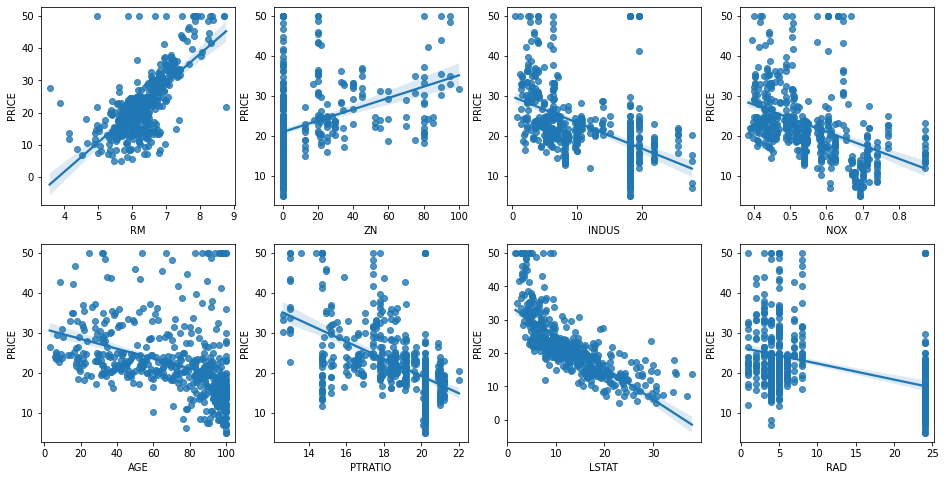

In [4]:
#2개의 행과 4개의 열을 가진 subplots이용. axs는 4*2개의 ax를 가짐.
fig, axs=plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features=['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
  row=int(i/4)
  col=i%4
  #시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
  sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

RM과 LSTAT의 영향도!

이제 보스턴 주택 가격의 회귀 모델을 만들자. 예측 수행하고 MSE, R2 Score 측정.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_data, y_target, test_size=0.3, random_state=156)

#선형 회귀 OLS로 학습/예측/평가 수행
lr=LinearRegression()
lr.fit(X_train, y_train)
y_preds=lr.predict(X_test)
mse=mean_squared_error(y_test, y_preds)
rmse=np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


모델의 절편과 회귀 계수 값을 보자.

In [6]:
print('절편 값:', lr.intercept_)
print('회귀 계수 값:', np.round(lr.coef_, 1))

절편 값: 40.99559517216477
회귀 계수 값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


coef_ 속성은 회귀 계수 값만 가지고 있으므로 이를 피처별 회귀 계수 값으로 다시 매핑하고 높은 값 순으로 출력한다.

In [8]:
#회귀 계수를 큰 값 순으로 정렬하기 위해 series로 생성, 인덱스 칼럼명에 유의.
coeff=pd.Series(data=np.round(lr.coef_,1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

역시 RM이 가장 크고 NOX 피처는 - 값이 너무 커 보인다. 최적화를 수행하자.

5개의 폴드 세트에서 cross_val_score 이용해 교차 검증으로 MSE와 RMSE를 측정. neg_mean_squared로 -1 곱하는 것 잊지 말기.

In [9]:
from sklearn.model_selection import cross_val_score

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr=LinearRegression()

#cross_val_score로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 RMSE 구함.
neg_mse_scores=cross_val_score(lr, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

#cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print('5 folds의 개별 negative mse scores:', np.round(neg_mse_scores, 2))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 2))
print('5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds의 개별 negative mse scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores: [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE : 5.829


cross_val_score로 반환된 값은 모두 음수임.